In [1]:
import gc
import glob
import os
import lightgbm as lgb
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from joblib import delayed, Parallel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")

def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

DATA_DIR = '/kaggle/input/optiver-realized-volatility-prediction'
# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.25
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# data configurations
USE_PRECOMPUTE_FEATURES = False  # Load precomputed features for train.csv from private dataset (just for speed up)


# for saving quota
IS_1ST_STAGE = True
SHORTCUT_NN_IN_1ST_STAGE = False  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
stock_ids = set(train['stock_id'])


In [2]:
import umap

In [3]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3

#This defines a type called DataBlock, which is used to specify whether data belongs to the training set, testing set, or both.
#TRAIN = 1 → Represents training data.
#TEST = 2 → Represents testing data.
#BOTH = 3 → Represents both training and testing data

def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, directory, f'stock_id={stock_id}'))
#This function loads stock market data from a file.
#stock_id: The ID of the stock.
#directory: Specifies which dataset (train/test).
#It reads a Parquet file (a type of data file format) containing stock data and returns it as a Pandas DataFrame.

def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

#Loads stock data based on whether it’s training, testing, or both.

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)

#These are wrapper functions to make it easier to load specific types of data:

def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

#These calculate the Weighted Average Price (WAP), a measure of price using both bid and ask prices.

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

#Computes realized volatility, which measures how much the stock price fluctuates.
#It squares each value in the series, sums them up, and takes the square root.

def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret

#Formats column names to include a prefix like book_ or trade_.


def make_book_feature(stock_id, block=DataBlock.TRAIN):
    book = load_book(stock_id, block)

    
    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)

    
    book['log_return1'] = book.groupby(['time_id'])['wap1'].transform(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].transform(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].transform(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].transform(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].transform(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].transform(log_return)

    # The rest of the code remains unchanged
    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))

    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread': [np.sum, np.mean, np.std],
        'bid_spread': [np.sum, np.mean, np.std],
        'ask_spread': [np.sum, np.mean, np.std],
        'total_volume': [np.sum, np.mean, np.std],
        'volume_imbalance': [np.sum, np.mean, np.std]
    }

    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id

    #Aggregates the data per time_id.

    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    #Adds time-based features (last 450, 300, and 150 seconds).
    return agg



def make_trade_feature(stock_id, block=DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].transform(log_return)

    features = {
        'log_return': [realized_volatility],
        'seconds_in_bucket': ['count'],
        'size': [np.sum],
        'order_count': [np.mean],
    }

    # Aggregating data at the 'time_id' level
    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id

    # Adding time-based features (450, 300, 150 seconds)
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    
    return agg
#Aggregates features like: Realized volatility, Order size, Number of orders



def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst
#Calculates the tick size (smallest price movement in stock trading).
#Uses np.diff() to find differences between unique price levels.



def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df
#Generates all features for multiple stocks in parallel.
#Merges book and trade data.
    

def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d

#Generates all features for multiple stocks in parallel.
#Merges book and trade data.

In [4]:
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather('features_v2.f')
else:
    df = make_features(train, DataBlock.TRAIN)
    df = make_features_v2(df, DataBlock.TRAIN)
    df.to_feather('features_v2.f')  # save cache


[books] 1267.254sec
[trades] 198.272sec
[extra features] 1.619sec
[books(v2)] 709.236sec


In [5]:
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True


#This is a memory stress test:
#If 1st stage testing is active and memory testing mode is on, it does NOT use the real test data.
#Instead, it copies the first 170,000 rows from the training data (df.iloc[:170000]) to simulate memory usage.
#Modifies the time_id column to avoid overlap with training data.
#Clears the row_id column (possibly because it's not relevant in this simulation).
#checks RAM usage and performance before actual deployment


if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)
    test_df = make_features_v2(test_df, DataBlock.TEST)
#make_features(test, DataBlock.TEST): Extracts trading-related features.
#make_features_v2(test_df, DataBlock.TEST): Enhances features with ticks.

print(df.shape) #(rows,columns)
print(test_df.shape) #(rows,columns)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

#Merges the test data (test_df) with the training data (df).
#Drops the row_id column before merging ( because it’s not needed).
#Resets the index to maintain a clean sequential order.

is 1st stage
[books] 0.176sec
[trades] 0.063sec
[extra features] 0.008sec
[books(v2)] 0.022sec
(428932, 216)
(3, 216)


In [6]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick
#Derives a price metric based on the smallest increment in price data.

def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df
#Compute a derived price for each time_id for a given stock file



In [7]:
import umap
import pandas as pd
import numpy as np
# import yfinance as yf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable

[load files] 0.352sec


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[calc prices] 43.892sec
[Spectral Embeddings] 6.960sec


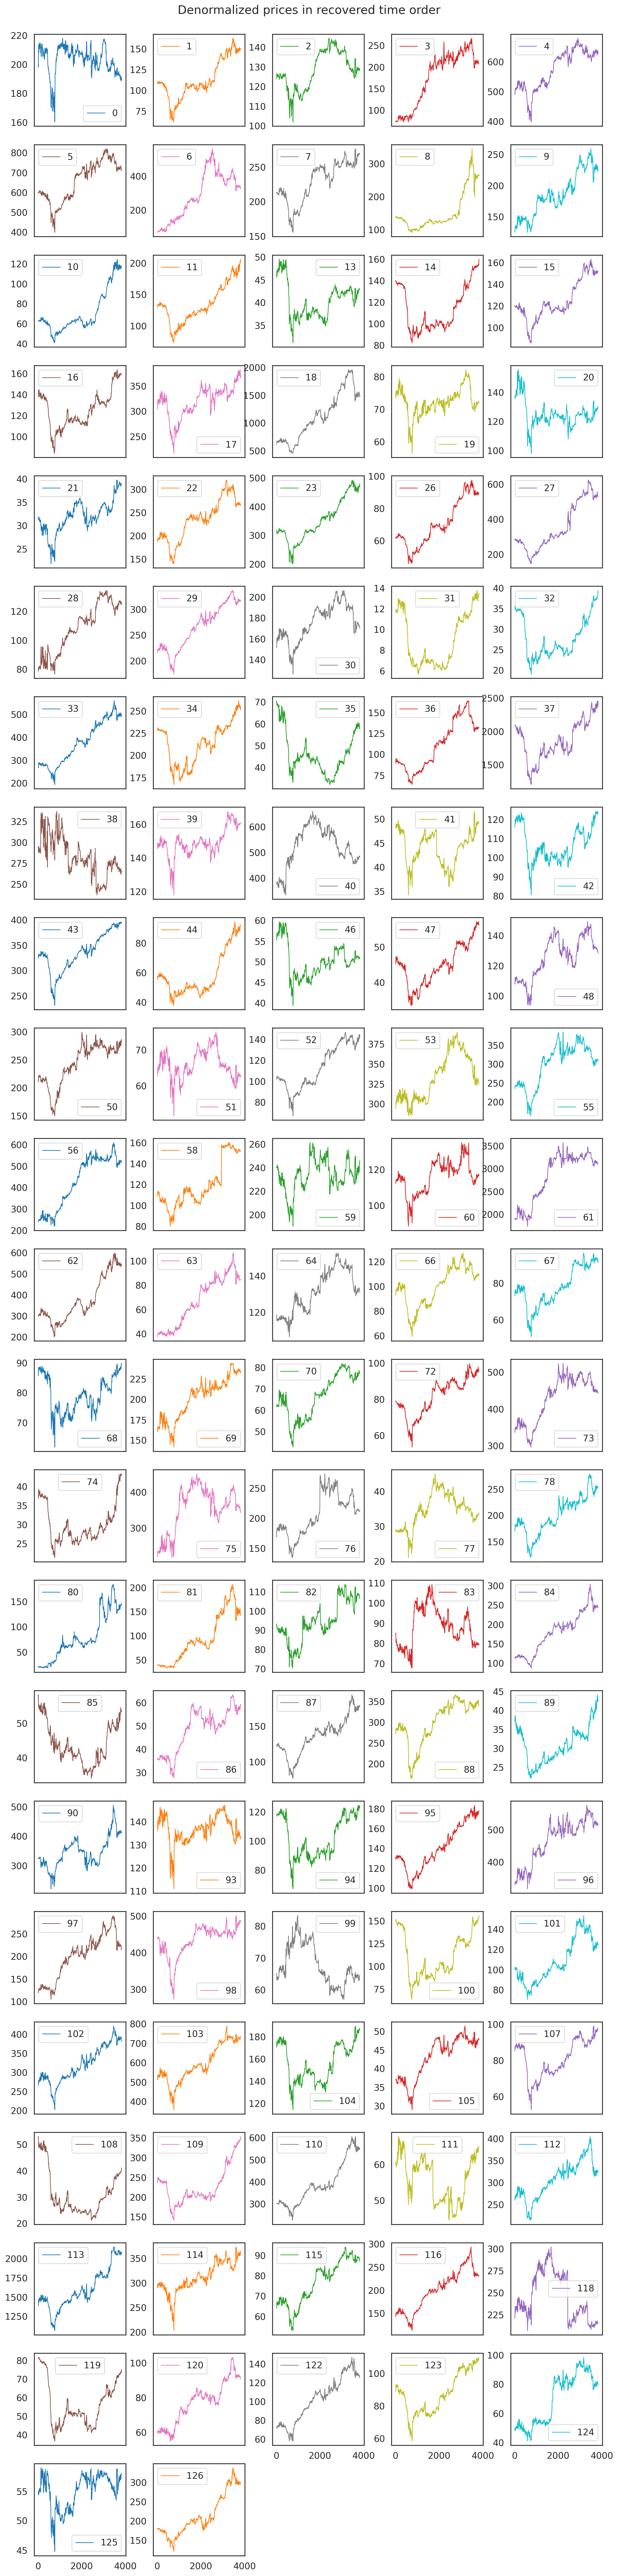

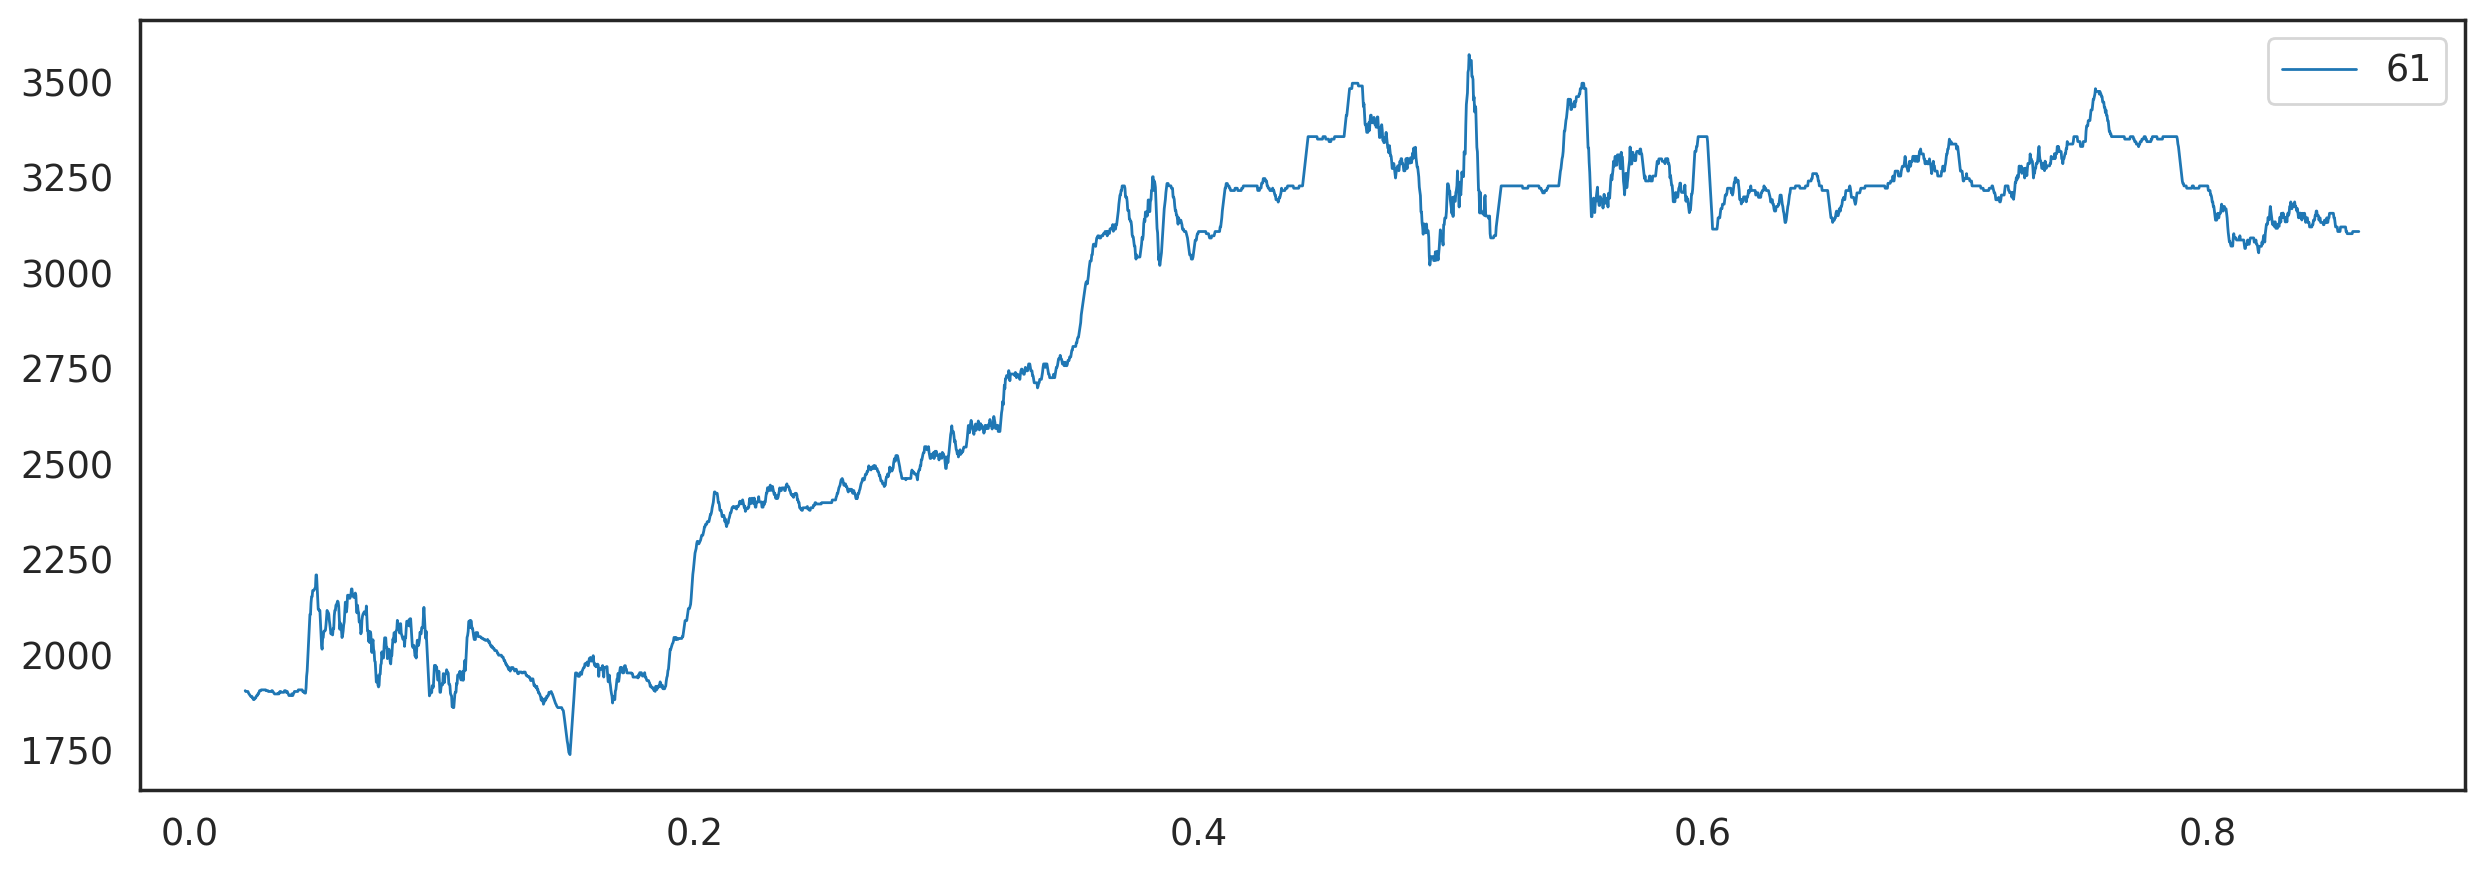

In [8]:
import glob

%config InlineBackend.figure_format = 'retina'
sns.set_theme('notebook', 'white', font_scale=1.2, palette='tab10')
from sklearn.manifold import TSNE, SpectralEmbedding
with timer('load files'):
        data_dir = 'data'
        df_files = pd.DataFrame(
            {'book_path': glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')
        df_target_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
        df_volatility_train = df_target_train.groupby('time_id').target.mean()


with timer('calc prices'):
        df_prices_denorm = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices_denorm = df_prices_denorm.pivot(index = 'time_id', columns= 'stock_id',values= 'price')
        df_prices_denorm_scaled = df_prices_denorm.fillna(df_prices_denorm.mean())
        df_prices_denorm_scaled = pd.DataFrame(minmax_scale(df_prices_denorm_scaled), index=df_prices_denorm.index)


    
with timer('Spectral Embeddings'):
        emb = SpectralEmbedding(random_state=2)
        emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
        df_prices_denorm_ordered = df_prices_denorm.iloc[np.argsort(-emb_denorm[:, 0])]
        df_prices_denorm_ordered.reset_index(drop=True).rolling(10).mean(). \
        plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1)
        plt.suptitle('Denormalized prices in recovered time order')
        plt.subplots_adjust(top=0.97, wspace=0.3);


    # AMZN
_, ax = plt.subplots(1, 1, figsize=(15, 5))
df_prices_denorm_ordered[61].rolling(10).mean().to_frame().set_index(np.linspace(0.02, 0.86, len(df_prices_denorm_ordered))).plot(lw=1, ax=ax);
    
timeid_order = pd.DataFrame(df_prices_denorm_ordered.index)


In [9]:
USE_PRECOMPUTE_FEATURES_1= False

In [10]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES_1:
            # Load precomputed time_id order
            timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
        else:
            # Use the existing time_id DataFrame
            timeid_order = timeid_order  # Replace `time_id_df` with your actual DataFrame variable name
            timeid_order['time_id_order'] = timeid_order.index  # Add an increasing index as the order
    print(timeid_order) 
    with timer('make folds'):
        # Map time_id_order to df
        df['time_id_order'] = df['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df = df.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)
        print(df)
        # Define fold boundaries
        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df['time_id_order']

        # Create folds
        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    # Clean up
    del df['time_id_order']

elif CV_SPLIT == 'group':
    # Use GroupKFold for cross-validation
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df, None, groups=df['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError("Invalid CV_SPLIT value. Use 'time' or 'group'.")

# Reset indices for df and df_test
df.reset_index(drop=True, inplace=True)
print(df)


[calculate order of time-id] 0.001sec
      time_id  time_id_order
0        7854              0
1       22487              1
2       20351              2
3       13421              3
4       13473              4
...       ...            ...
3825    12182           3825
3826     2867           3826
3827    18077           3827
3828    32704           3828
3829    27524           3829

[3830 rows x 2 columns]
        stock_id  time_id    target  book.seconds_in_bucket.count  \
0              0     7854  0.001480                         287.0   
1              1     7854  0.001215                         191.0   
2              2     7854  0.001234                         280.0   
3              3     7854  0.002602                         216.0   
4              4     7854  0.001994                         138.0   
...          ...      ...       ...                           ...   
428930       125    27524  0.001462                         487.0   
428931       126    27524  0.004248  

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value enc

In [11]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import Optional, Dict

N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame,        
                 p: float,                   
                 metric: str = 'minkowski',  
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):

        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric

        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None  

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:                                     
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0
        pivot_aggs = np.nanmean(self.feature_values[start:n, :, :], axis=0) 

        pivot_aggs = np.nan_to_num(pivot_aggs, nan=np.nanmean(pivot_aggs))

        pivot_aggs = pd.DataFrame(
            pivot_aggs, 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst

class TimeIdNeighbors(Neighbors): 
    """Finds nearest neighbors in time while ensuring causality (including itself)."""

    def get_causal_neighbors(self):
        """Ensures nearest neighbors only use past observations, including itself."""
        n_samples = len(self.pivot)
        self.neighbors = np.full((n_samples, N_NEIGHBORS_MAX), fill_value=-1, dtype=int)  # Initialize

        for i in range(n_samples):
            # Include self in the search space
            past_data = self.pivot.iloc[:i]  # Includes all rows up to index i (including itself)
            
            nn = NearestNeighbors(n_neighbors=min(N_NEIGHBORS_MAX, len(past_data)), p=self.p, metric=self.metric)
            nn.fit(past_data)  # Fit on past data (including self)
            
            _, indices = nn.kneighbors(self.pivot.iloc[[i]], return_distance=True)
            self.neighbors[i, :len(indices[0])] = indices[0]  # Store neighbors

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)
        feature_pivot.fillna(feature_pivot.mean(), inplace=True)

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))
        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)
        feature_pivot.fillna(feature_pivot.mean(), inplace=True)

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))
        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col


class StockIdNeighbors(Neighbors):                     
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)

        # Step 1: Row-wise filling using row means
        feature_pivot = feature_pivot.apply(lambda row: row.fillna(row.mean()), axis=1)

        # Step 2: Column-wise filling using column means
        feature_pivot.fillna(feature_pivot.mean(), inplace=True)

        # Step 3: Final safety fill for any remaining NaNs
        feature_pivot.fillna(0, inplace=True)
        if feature_pivot.isnull().sum().sum() > 0:
            print(f"⚠ ERROR: NaNs remain in feature_pivot even after filling! Count: {feature_pivot.isnull().sum().sum()}")
            print(f"[DEBUG] Feature Pivot Table Sample with NaNs:\n{feature_pivot.head(10)}")
            raise ValueError("Feature pivot table still contains NaNs after filling. Investigate missing stock_id/time_id combinations.")
        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] = feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col


# Helper to calculate inverse covariance matrix for Mahalanobis distance
def compute_inverse_covariance(pivot: pd.DataFrame) -> np.ndarray:
    """Computes the inverse covariance matrix for Mahalanobis distance."""
    cov_matrix = np.cov(pivot.values.T)  # Compute covariance matrix
    return np.linalg.inv(cov_matrix)  # Inverse of the covariance matrix



In [12]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])

#These lines transform the "seconds_in_bucket.count" columns using:
#"seconds_in_bucket.count" represents the number of trades recorded within a given time bucket.
#The transformation creates a feature (tau) that scales inversely with the number of trades.

#Why use this formula?
#Higher trade counts → Lower tau

#If a time bucket has many trades, tau will be small. This means high trading activity leads to a smaller feature value.
#Fewer trades → Higher tau

#If a time bucket has fewer trades, tau will be larger.This suggests that less frequent trading might indicate illiquidity or high volatility.
#KNN-based features depend on such transformations.

df['real_price'] = 0.01 / df['tick_size']

#tick_size represents the minimum price movement (e.g., smallest allowed price change in the stock). This formula computes a normalized price feature.
# Why use this formula?
#Higher tick size → Lower real_price

#If a stock has a large tick_size (e.g., minimum price move is $0.05 instead of $0.01), then real_price will be smaller. 
#This suggests that the stock is less liquid or has larger price jumps.
#Lower tick size → Higher real_price

#If tick_size is very small (e.g., $0.0001), then real_price will be larger.
#This indicates a highly liquid stock with fine-grained price movements.



In [13]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']
#This creates a Feature Pivot Table (df_pv) that selects key features.   
    
    if USE_PRICE_NN_FEATURES:  # Use nearest neighbor features that rely on tick size
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'price')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    #Pivot table: Converts df_pv into a matrix where:
    #Rows → time_id
    #Columns → stock_id
    #Values → price
    
    #Min-Max Scaling: Normalizes prices for proper distance calculations.
    
    #Different Distance Metrics:
    #Canberra Distance (canberra): Sensitive to small differences.
    #Mahalanobis Distance (mahalanobis): Accounts for covariance structure.
    #L1 Distance (p=1): Manhattan distance for stock-based neighbors.
    
    if USE_VOL_NN_FEATURES:  # Use nearest neighbor features that can be calculated without tick size
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )
#Same logic as price-based features but using realized volatility.
#Uses L1 distance (Manhattan distance) for neighbor search.


    if USE_SIZE_NN_FEATURES:  # Use nearest neighbor features that can be calculated without tick size
        pivot = df_pv.pivot(index='time_id',columns= 'stock_id', values='trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )

#Uses total trade size (sum of book order volumes).
#Uses Mahalanobis and Canberra distances.

        
    if USE_RANDOM_NN_FEATURES:  # Use random index to aggregate neighbors
        pivot = df_pv.pivot(index='time_id', columns= 'stock_id',values= 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), 
                p=2,
                metric='random')
        )
#Randomly selects neighbors instead of using distance metrics

if not USE_TIME_ID_NN:      # Disable time-based neighbors if flag is False
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:    # Disable stock-based neighbors if flag is False
    stock_id_neighbors = []

[knn fit] 199.503sec


In [14]:
import pandas as pd
import seaborn as sns
import numpy as np

def calculate_rank_correlation(neighbors, top_n=5):
    # Check if there are neighbors to process
    if not neighbors:
        return
    
    # Create an empty DataFrame to store the neighbor indices
    neighbor_indices = pd.DataFrame()
    
    # Iterate over each neighbor object and collect its indices for the top_n neighbors
    for n in neighbors:
        # Get the top N neighbors and flatten it
        # The idea is to flatten the list of neighbor indices for each 'n'
        neighbor_indices[n.name] = n.neighbors[:, :top_n].flatten()
    
    # Compute the Kendall rank correlation
    correlation_matrix = neighbor_indices.corr(method='kendall')
    
    # Plot the heatmap of Kendall correlation
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

#Computes the Kendall rank correlation between different neighbor methods.
#Kendall correlation measures the similarity in rankings between two datasets.
#Why Kendall?
#It is good for ordinal data (like ranks).
#Less sensitive to outliers than Pearson/Spearman.

In [15]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  30183  31471  26708   7864  22752  10619  11453   1205    9352
11          11   2811  29583  30798  17639  25131  23202  14857   4739    3399
16          16   5829   4275   7783   4487   7845  25439  17530  18634   19747
31          31   6367  19386   1255  12559  19472  18358  31719   6481   26475
32          32     34      4  31554  24443   5916  19164  20430    659   31077

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  31471  11453  30183   7864  26708   4091  30430  22752    9889
11          11   2811  29583  30798  14857   4739  17639  25131  23202   13745
16          16   4275  18634   5829  25439  17530   7783   4034   4487   19747
31          31  12559  17429  26475  31719  18358   6481   7897  12348    9456
32          32     34      4   5916  31554  19164   6213    659  25636   24443

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5   9352  15276  13791   1205  12923  26708   2331   2136   10672
11          11  23202  30798  17639   7460  29583  11227   2811  25131   32597
16          16   9060  25179  25439  21777  15727  17530   6476    211   30791
31          31  10291  15689  18848  22824  14449   1142   6367  21148   25731
32          32     34      4  25584  26883   5235   2772  26430   2502   22014

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  30183  23490  22752  26708  20928  13791   1350  31883   10619
11          11  29583  19417   9822  23656   4367  22828  30798  11682   10745
16          16  25439   6121   8168  31443   7845  14721   1040  20630   11497
31          31  13594  16802  20099  31719   1239  19472   3846  12559   13989
32          32     34      4  22014   6482  27822   1392   9215  24921   30803

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  26708  30183  22752   1205  10619   9352  15276  30620    2683
11          11   2811  17639  29583  25131  28020  17604   9822   4739   30798
16          16   5829   4487   6121   7783   1040  29026   7845  17530   16118
31          31   6367  12559  22519  18358   7897  19472  31522  19386   31719
32          34     32      4  15989  11985   3732  26430   3607  10523    4487

In [16]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).loc[64]
    )
#Extracts unique stock_ids and sorts them in ascending order.
#Iterates over each StockIdNeighbors object.
#Prints details of each neighbor model.
#Creates a DataFrame to map each stock_id to its top 10 nearest neighbors.
#Displays the row corresponding to stock_id 64, showing its top 10 nearest neighbors.

top_1      64
top_2      53
top_3      56
top_4     124
top_5      73
top_6      96
top_7      30
top_8      28
top_9      66
top_10     33
Name: 64, dtype: int64

top_1      64
top_2      20
top_3      93
top_4      67
top_5      52
top_6     107
top_7      70
top_8     120
top_9     102
top_10     39
Name: 64, dtype: int64

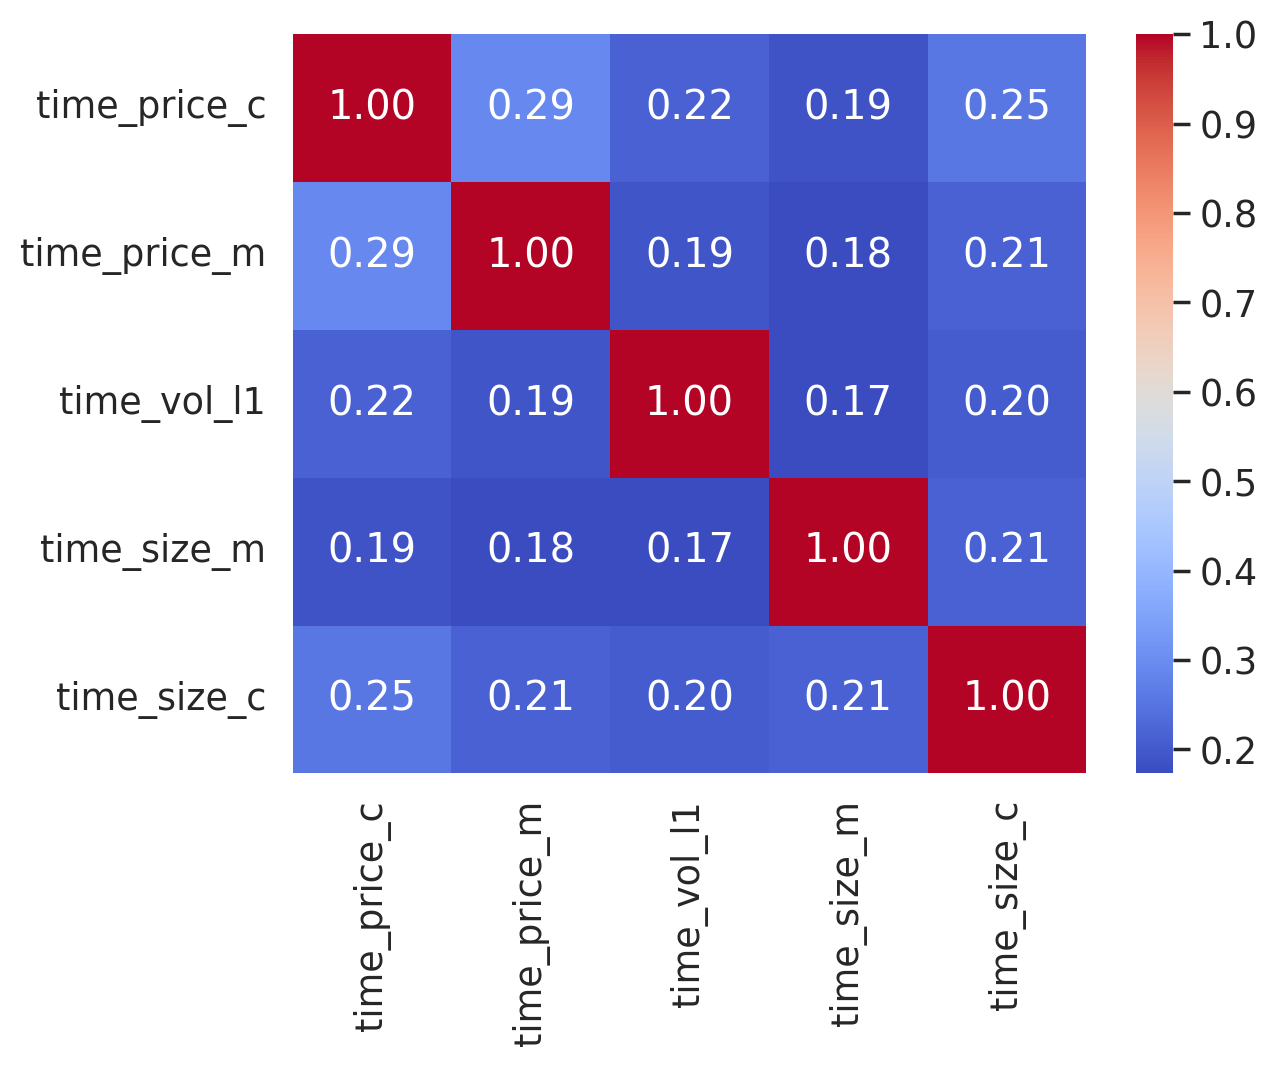

In [17]:
calculate_rank_correlation(time_id_neighbors)

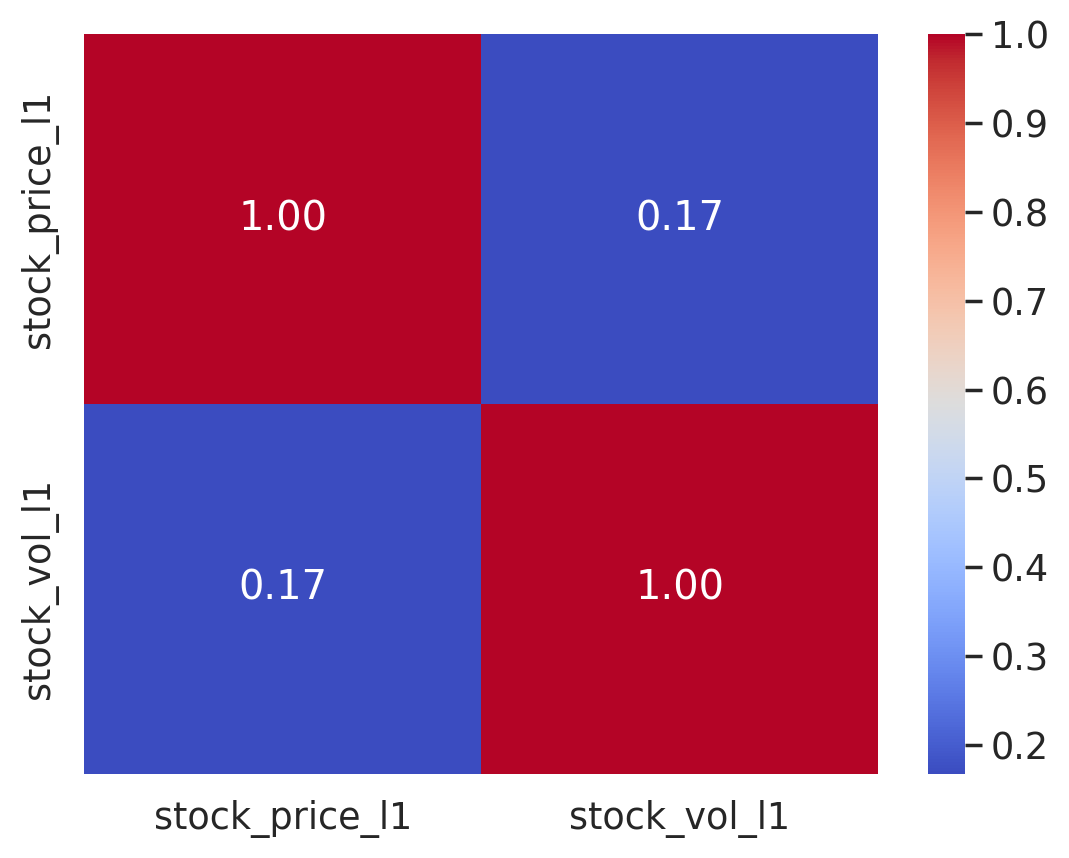

In [18]:
calculate_rank_correlation(stock_id_neighbors)

In [19]:
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

In [20]:
import gc
import pandas as pd
import numpy as np


#Takes: A pandas DataFrame (df) with stock and market data.
#Returns: A modified DataFrame (df2) with additional nearest neighbor-based features.
#Main Goal: Compute statistical aggregations (mean, min, max, std) over neighboring stocks and time points.


def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }

    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neighbor_sizes = [3, 5, 10, 20, 40]
    time_id_neighbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf = None
    feature_list = []

    # Neighbor stock_id
    for feature_col in feature_cols_stock.keys():
        try:
            if feature_col not in df2.columns:
                print(f"Column {feature_col} is skipped")
                continue

            if not stock_id_neighbors:
                continue

            for nn in stock_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes:
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            feature_list.append(dst)
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    # Merge stock_id neighbor features
    if feature_list:
        ndf = pd.concat(feature_list, axis=1)
        ndf = ndf.loc[:, ~ndf.columns.duplicated()]  # Remove duplicate columns
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left', validate="one_to_one")
    feature_list.clear()
    ndf = None

    print(df2.shape)

    # Neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col =='real_price':
                continue
            if feature_col not in df2.columns:
                print(f"Column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            time_id_ns = time_id_neighbor_sizes_vol if 'volatility' in feature_col else time_id_neighbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            feature_list.append(dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    # Merge time_id neighbor features
    if feature_list:
        ndf = pd.concat(feature_list, axis=1)
        ndf = ndf.loc[:, ~ndf.columns.duplicated()]  # Remove duplicate columns
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left', validate="one_to_one")
    feature_list.clear()
    ndf = None

    # Additional derived features
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neighbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"
                if f"{denominator}_min" in df2.columns:
                    df2[f'real_price_rankmin_{sz}'] = df2['real_price'] / df2[f"{denominator}_min"]
                else:
                    print(f"Missing column: {denominator}_min")
                if f"{denominator}_max" in df2.columns:
                    df2[f'real_price_rankmax_{sz}'] = df2['real_price'] / df2[f"{denominator}_max"]
                else:
                    print(f"Missing column: {denominator}_max")
                if f"{denominator}_mean" in df2.columns:
                    df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]
                else:
                    print(f"Missing column: {denominator}_mean")
            for sz in time_id_neighbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"
                if f"{denominator}_min" in df2.columns:
                    df2[f'vol_rankmin_{sz}'] = df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_min"]
                else:
                    print(f"Missing column: {denominator}_min")
                if f"{denominator}_max" in df2.columns:
                    df2[f'vol_rankmax_{sz}'] = df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_max"]
                else:
                    print(f"Missing column: {denominator}_max")

    

        # Remove unnecessary price columns
        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        df2.drop(columns=price_cols, inplace=True, errors='ignore')

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neighbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                if tgt in df2.columns:
                    df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')

    return df2



In [21]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')
print(df2)
gc.collect()


(428935, 220)
(428935, 280)
[make nearest neighbor feature] 704.130sec
(428935, 582)
        stock_id  time_id    target  book.seconds_in_bucket.count  \
0              0     7854  0.001480                         287.0   
1              1     7854  0.001215                         191.0   
2              2     7854  0.001234                         280.0   
3              3     7854  0.002602                         216.0   
4              4     7854  0.001994                         138.0   
...          ...      ...       ...                           ...   
428930       125    27524  0.001462                         487.0   
428931       126    27524  0.004248                         228.0   
428932         0        4       NaN                           3.0   
428933         0       32       NaN                           NaN   
428934         0       34       NaN                           NaN   

        book.wap1.sum  book.wap1.mean  book.wap1.std  book.wap2.sum  \
0          287.

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0

In [22]:
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
#This list contains column name patterns that indicate skewed data.
#These columns represent trade sizes and volume imbalances, which can have a long-tailed distribution (some values much larger than others).
#Applying a log transformation reduces the impact of large outliers.
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')
#If any error occurs (e.g., df2[c] contains non-numeric values), it logs the error using print_trace('log1p').


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
#Computes rolling mean features for book.log_return1.realized_volatility, grouped by stock_id, and merges them back into df2
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)

#Sorts df2 by:
#stock_id (to ensure each stock's data is processed sequentially).
#book.total_volume.sum (ensures rolling calculations are performed in the correct order).
#Resets the index after sorting (drops old index and assigns new sequential indices)

    
    roll_target = 'book.log_return1.realized_volatility'
    roll_features = {}

    #Iterates over two window sizes: 3 and 10. Short and longer term trend.

    for window_size in [3, 10]:
        roll_features[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = (
            df2.groupby('stock_id')[roll_target]
               .transform(lambda x: x.rolling(window_size, center=True, min_periods=1).mean())
        )

    # Use `pd.concat()` to merge new rolling features at once
    df2 = pd.concat([df2, pd.DataFrame(roll_features)], axis=1)

except Exception:
    print_trace('mean RV')




In [24]:
# stock-id embedding (helps little)
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot(index='time_id', columns = 'stock_id', values = 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

#Why Use LDA for Stock Embeddings?
#Reduces dimensionality – Instead of handling thousands of individual stocks, we capture key patterns in a few features.
# Finds hidden relationships – Stocks that behave similarly (e.g., tech stocks) will have similar embeddings.
# Improves ML models – These embeddings can be used as input features for stock price prediction models.



In [25]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

54

In [26]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())
#Checks that all models use the same features.
    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    #Runs predictions for each model and stores them in predicted[:, i].
    #If weights are given, normalizes predictions using np.sum(self.weights). Otherwise, averages predictions across models.
    
    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()



In [27]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
]


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def qlike_from_rv(y_true, y_pred):
    eps = 1e-9
    y_true = np.array(y_true) + eps
    y_pred = np.array(y_pred) + eps
    return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)

class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module):
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs



def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")
            try:
                qlike_val = qlike_from_rv(valid_targets, predictions)
                print(f"          QLIKE: {qlike_val:.5f}")
            except Exception as e:
                print(f"          QLIKE calculation error: {e}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler

In [28]:
X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')
X_test = get_X(df_test)
print(X_test.shape)

(3, 584)


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

del df, df_train
gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]


model_paths = []
scores = []
    
if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
    print('shortcut to save quota...')
    epochs = 3
    valid_th = 100
else:
    epochs = 30
    valid_th = NN_VALID_TH
    
for i in range(NN_NUM_MODELS):
        # MLP
    nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
    if nn_losses[0] < NN_VALID_TH:
        print(f'model of seed {i} added.')
        scores.append(nn_losses[0])
        model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
        np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
mlp_model = [torch.load(path, device) for path in model_paths]
print(f'total {len(mlp_model)} models will be used.')
X_num_val, X_cat_val, cat_cols_val = preprocess_nn(X.copy(), scaler=scaler)
X_num_val = X_num_val[folds[-1][1]]
X_cat_val = X_cat_val[folds[-1][1]]
y_val_true = y.values[folds[-1][1]]

val_dataset = TabularDataset(X_num_val, X_cat_val, y_val_true)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)

all_preds = []

for model in mlp_model:
    model.eval()
    preds = []
    with torch.no_grad():
        for x_num, x_cat, _ in val_loader:
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            output = model(x_num, x_cat).detach().cpu().numpy()
            preds.append(output)
    preds = np.concatenate(preds)
    all_preds.append(preds)

# Ensemble prediction
ensemble_preds = np.mean(np.stack(all_preds), axis=0)

# Compute metrics
final_rmspe = rmspe_metric(y_val_true, ensemble_preds)
final_qlike = qlike_from_rv(y_val_true, ensemble_preds)

print("\n==============================")
print("Ensemble Evaluation on Validation Fold:")
print(f"Average RMSPE: {final_rmspe:.5f}")
print(f"Average QLIKE: {final_qlike:.5f}")
print("==============================")


cpu
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.94it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 21.632, valid rmspe: 9.906
          QLIKE: nan
new best:9.905778884887695


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.90it/s]


epoch 1, train loss: 6.178, valid rmspe: 5.670
          QLIKE: nan
new best:5.669912815093994


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.51it/s]


epoch 2, train loss: 5.875, valid rmspe: 4.006
          QLIKE: nan
new best:4.006373405456543


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.67it/s]


epoch 3, train loss: 2.285, valid rmspe: 1.963
          QLIKE: 0.32673
new best:1.963407278060913


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.08it/s]


epoch 4, train loss: 1.029, valid rmspe: 0.879
          QLIKE: nan
new best:0.8794865012168884


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.00it/s]


epoch 5, train loss: 0.672, valid rmspe: 1.225
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.47it/s]


epoch 6, train loss: 0.690, valid rmspe: 0.294
          QLIKE: 0.02803
new best:0.29422223567962646


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.17it/s]


epoch 7, train loss: 0.611, valid rmspe: 0.441
          QLIKE: 0.04666


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.30it/s]


epoch 8, train loss: 0.435, valid rmspe: 0.289
          QLIKE: 0.02800
new best:0.2889392673969269


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.80it/s]


epoch 9, train loss: 0.377, valid rmspe: 0.325
          QLIKE: 0.03218


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.08it/s]


epoch 10, train loss: 0.358, valid rmspe: 0.421
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.12it/s]


epoch 11, train loss: 0.403, valid rmspe: 0.238
          QLIKE: 0.02933
new best:0.23819458484649658


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 51.90it/s]


epoch 12, train loss: 0.436, valid rmspe: 0.394
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.31it/s]


epoch 13, train loss: 0.361, valid rmspe: 0.239
          QLIKE: 0.05334


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.89it/s]


epoch 14, train loss: 0.334, valid rmspe: 0.510
          QLIKE: 0.05999


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.32it/s]


epoch 15, train loss: 0.318, valid rmspe: 0.211
          QLIKE: 0.03701
new best:0.2108723223209381


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.33it/s]


epoch 16, train loss: 0.276, valid rmspe: 0.445
          QLIKE: 0.04967


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.04it/s]


epoch 17, train loss: 0.303, valid rmspe: 0.551
          QLIKE: 0.06743


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.29it/s]


epoch 18, train loss: 0.285, valid rmspe: 0.305
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.02it/s]


epoch 19, train loss: 0.268, valid rmspe: 0.209
          QLIKE: 0.01904
new best:0.2085023671388626


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 52.79it/s]


epoch 20, train loss: 0.242, valid rmspe: 0.282
          QLIKE: 0.08153


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.54it/s]


epoch 21, train loss: 0.240, valid rmspe: 0.197
          QLIKE: 0.03085
new best:0.1971120685338974


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.58it/s]


epoch 22, train loss: 0.231, valid rmspe: 0.183
          QLIKE: 0.02409
new best:0.18318277597427368


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.00it/s]


epoch 23, train loss: 0.225, valid rmspe: 0.232
          QLIKE: 0.04707


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.41it/s]


epoch 24, train loss: 0.220, valid rmspe: 0.180
          QLIKE: 0.02156
new best:0.180006742477417


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.54it/s]


epoch 25, train loss: 0.212, valid rmspe: 0.212
          QLIKE: 0.03736


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.31it/s]


epoch 26, train loss: 0.206, valid rmspe: 0.186
          QLIKE: 0.01801


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.77it/s]


epoch 27, train loss: 0.204, valid rmspe: 0.178
          QLIKE: 0.01932
new best:0.17764240503311157


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.18it/s]


epoch 28, train loss: 0.202, valid rmspe: 0.180
          QLIKE: 0.02263


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 53.41it/s]


epoch 29, train loss: 0.201, valid rmspe: 0.178
          QLIKE: 0.02070
new best:0.17764045298099518
model of seed 0 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.35it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 25.337, valid rmspe: 9.744
          QLIKE: nan
new best:9.743915557861328


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.03it/s]


epoch 1, train loss: 6.573, valid rmspe: 1.336
          QLIKE: nan
new best:1.3355423212051392


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.40it/s]


epoch 2, train loss: 5.964, valid rmspe: 2.208
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 46.62it/s]


epoch 3, train loss: 1.573, valid rmspe: 1.195
          QLIKE: nan
new best:1.1954314708709717


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.80it/s]


epoch 4, train loss: 0.710, valid rmspe: 0.740
          QLIKE: nan
new best:0.7396013140678406


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.31it/s]


epoch 5, train loss: 0.610, valid rmspe: 0.356
          QLIKE: 0.03767
new best:0.3564014136791229


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.09it/s]


epoch 6, train loss: 0.573, valid rmspe: 0.819
          QLIKE: 0.11441


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.05it/s]


epoch 7, train loss: 0.568, valid rmspe: 0.507
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.16it/s]


epoch 8, train loss: 0.462, valid rmspe: 0.222
          QLIKE: 0.04209
new best:0.22156739234924316


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.30it/s]


epoch 9, train loss: 0.481, valid rmspe: 0.734
          QLIKE: 0.09911


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.67it/s]


epoch 10, train loss: 0.454, valid rmspe: 0.269
          QLIKE: 0.07389


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.43it/s]


epoch 11, train loss: 0.393, valid rmspe: 0.683
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.33it/s]


epoch 12, train loss: 0.437, valid rmspe: 0.240
          QLIKE: 0.05155


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.96it/s]


epoch 13, train loss: 0.401, valid rmspe: 0.502
          QLIKE: 0.05971


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.28it/s]


epoch 14, train loss: 0.366, valid rmspe: 0.203
          QLIKE: 0.01954
new best:0.20303082466125488


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.60it/s]


epoch 15, train loss: 0.296, valid rmspe: 0.493
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 38.96it/s]


epoch 16, train loss: 0.297, valid rmspe: 0.288
          QLIKE: 0.02751


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.60it/s]


epoch 17, train loss: 0.308, valid rmspe: 0.194
          QLIKE: 0.02790
new best:0.19396302103996277


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.65it/s]


epoch 18, train loss: 0.282, valid rmspe: 0.272
          QLIKE: 0.02611


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.47it/s]


epoch 19, train loss: 0.267, valid rmspe: 0.180
          QLIKE: 0.01909
new best:0.17976313829421997


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.37it/s]


epoch 20, train loss: 0.256, valid rmspe: 0.186
          QLIKE: 0.02365


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.74it/s]


epoch 21, train loss: 0.242, valid rmspe: 0.186
          QLIKE: 0.02006


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.88it/s]


epoch 22, train loss: 0.234, valid rmspe: 0.384
          QLIKE: 0.03987


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.20it/s]


epoch 23, train loss: 0.224, valid rmspe: 0.178
          QLIKE: 0.02004
new best:0.177835151553154


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.99it/s]


epoch 24, train loss: 0.213, valid rmspe: 0.178
          QLIKE: 0.01984
new best:0.17775721848011017


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.93it/s]


epoch 25, train loss: 0.210, valid rmspe: 0.177
          QLIKE: 0.02018
new best:0.1774936467409134


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.59it/s]


epoch 26, train loss: 0.205, valid rmspe: 0.181
          QLIKE: 0.02329


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.04it/s]


epoch 27, train loss: 0.204, valid rmspe: 0.178
          QLIKE: 0.02165


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.97it/s]


epoch 28, train loss: 0.201, valid rmspe: 0.177
          QLIKE: 0.01917
new best:0.17686966061592102


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.65it/s]


epoch 29, train loss: 0.199, valid rmspe: 0.177
          QLIKE: 0.02030
new best:0.1768520325422287
model of seed 1 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.39it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 23.696, valid rmspe: 6.324
          QLIKE: nan
new best:6.323916435241699


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.89it/s]


epoch 1, train loss: 5.861, valid rmspe: 9.347
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.80it/s]


epoch 2, train loss: 5.552, valid rmspe: 3.851
          QLIKE: nan
new best:3.850867509841919


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.88it/s]


epoch 3, train loss: 2.183, valid rmspe: 0.567
          QLIKE: 0.07746
new best:0.5667188763618469


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.39it/s]


epoch 4, train loss: 0.818, valid rmspe: 0.612
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.58it/s]


epoch 5, train loss: 0.583, valid rmspe: 0.514
          QLIKE: nan
new best:0.5139566659927368


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.04it/s]


epoch 6, train loss: 0.542, valid rmspe: 0.301
          QLIKE: 0.03820
new best:0.30085375905036926


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.74it/s]


epoch 7, train loss: 0.588, valid rmspe: 0.640
          QLIKE: 0.08388


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.14it/s]


epoch 8, train loss: 0.438, valid rmspe: 0.259
          QLIKE: 0.02451
new best:0.25901177525520325


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.18it/s]


epoch 9, train loss: 0.471, valid rmspe: 0.538
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.83it/s]


epoch 10, train loss: 0.462, valid rmspe: 0.434
          QLIKE: 0.04782


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.71it/s]


epoch 11, train loss: 0.417, valid rmspe: 0.740
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.63it/s]


epoch 12, train loss: 0.428, valid rmspe: 0.459
          QLIKE: 0.05292


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.75it/s]


epoch 13, train loss: 0.447, valid rmspe: 0.404
          QLIKE: 0.19364


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.34it/s]


epoch 14, train loss: 0.367, valid rmspe: 0.648
          QLIKE: 0.08414


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.33it/s]


epoch 15, train loss: 0.363, valid rmspe: 0.228
          QLIKE: 0.02177
new best:0.22809359431266785


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.13it/s]


epoch 16, train loss: 0.339, valid rmspe: 0.362
          QLIKE: 0.03654


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.86it/s]


epoch 17, train loss: 0.317, valid rmspe: 0.401
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.26it/s]


epoch 18, train loss: 0.291, valid rmspe: 0.464
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.90it/s]


epoch 19, train loss: 0.275, valid rmspe: 0.216
          QLIKE: 0.01995
new best:0.21641726791858673


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 53.39it/s]


epoch 20, train loss: 0.257, valid rmspe: 0.190
          QLIKE: 0.02724
new best:0.18969763815402985


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 44.68it/s]


epoch 21, train loss: 0.252, valid rmspe: 0.207
          QLIKE: 0.01978


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.61it/s]


epoch 22, train loss: 0.247, valid rmspe: 0.183
          QLIKE: 0.01847
new best:0.183278426527977


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.97it/s]


epoch 23, train loss: 0.234, valid rmspe: 0.207
          QLIKE: 0.01971


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 37.30it/s]


epoch 24, train loss: 0.215, valid rmspe: 0.183
          QLIKE: 0.02406
new best:0.18275617063045502


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.56it/s]


epoch 25, train loss: 0.211, valid rmspe: 0.203
          QLIKE: 0.03331


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.07it/s]


epoch 26, train loss: 0.207, valid rmspe: 0.178
          QLIKE: 0.02097
new best:0.17791910469532013


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.51it/s]


epoch 27, train loss: 0.203, valid rmspe: 0.184
          QLIKE: 0.02439


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.75it/s]


epoch 28, train loss: 0.202, valid rmspe: 0.178
          QLIKE: 0.02120


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.37it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.177
          QLIKE: 0.01970
new best:0.17712758481502533
model of seed 2 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.49it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 25.345, valid rmspe: 2.495
          QLIKE: nan
new best:2.4949824810028076


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 46.72it/s]


epoch 1, train loss: 5.994, valid rmspe: 5.394
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.89it/s]


epoch 2, train loss: 4.399, valid rmspe: 2.630
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.96it/s]


epoch 3, train loss: 1.675, valid rmspe: 0.662
          QLIKE: 0.07564
new best:0.6620928049087524


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 38.21it/s]


epoch 4, train loss: 0.819, valid rmspe: 1.193
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.65it/s]


epoch 5, train loss: 0.712, valid rmspe: 0.275
          QLIKE: 0.07805
new best:0.27483659982681274


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.95it/s]


epoch 6, train loss: 0.594, valid rmspe: 0.424
          QLIKE: 0.31768


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.31it/s]


epoch 7, train loss: 0.469, valid rmspe: 0.358
          QLIKE: 0.03694


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.61it/s]


epoch 8, train loss: 0.402, valid rmspe: 0.561
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.38it/s]


epoch 9, train loss: 0.380, valid rmspe: 0.342
          QLIKE: 0.03464


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.69it/s]


epoch 10, train loss: 0.447, valid rmspe: 0.221
          QLIKE: 0.02036
new best:0.22080984711647034


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.29it/s]


epoch 11, train loss: 0.395, valid rmspe: 0.190
          QLIKE: 0.02029
new best:0.19001369178295135


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.54it/s]


epoch 12, train loss: 0.362, valid rmspe: 0.588
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.69it/s]


epoch 13, train loss: 0.362, valid rmspe: 0.336
          QLIKE: 0.12854


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.37it/s]


epoch 14, train loss: 0.340, valid rmspe: 0.191
          QLIKE: 0.02046


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.50it/s]


epoch 15, train loss: 0.334, valid rmspe: 0.221
          QLIKE: 0.04176


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.72it/s]


epoch 16, train loss: 0.298, valid rmspe: 0.243
          QLIKE: 0.05305


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.67it/s]


epoch 17, train loss: 0.273, valid rmspe: 0.500
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.24it/s]


epoch 18, train loss: 0.268, valid rmspe: 0.206
          QLIKE: 0.03479


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.62it/s]


epoch 19, train loss: 0.269, valid rmspe: 0.207
          QLIKE: 0.03472


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.18it/s]


epoch 20, train loss: 0.244, valid rmspe: 0.226
          QLIKE: 0.02051


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.99it/s]


epoch 21, train loss: 0.242, valid rmspe: 0.194
          QLIKE: 0.02788


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.55it/s]


epoch 22, train loss: 0.233, valid rmspe: 0.194
          QLIKE: 0.02923


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.14it/s]


epoch 23, train loss: 0.219, valid rmspe: 0.180
          QLIKE: 0.02050
new best:0.17975769937038422


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.49it/s]


epoch 24, train loss: 0.213, valid rmspe: 0.184
          QLIKE: 0.02225


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 45.46it/s]


epoch 25, train loss: 0.212, valid rmspe: 0.183
          QLIKE: 0.02398


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.31it/s]


epoch 26, train loss: 0.209, valid rmspe: 0.180
          QLIKE: 0.02276


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.84it/s]


epoch 27, train loss: 0.203, valid rmspe: 0.177
          QLIKE: 0.01985
new best:0.17696593701839447


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.92it/s]


epoch 28, train loss: 0.200, valid rmspe: 0.178
          QLIKE: 0.02153


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.71it/s]


epoch 29, train loss: 0.199, valid rmspe: 0.177
          QLIKE: 0.02011
model of seed 3 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.89it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 24.240, valid rmspe: 10.053
          QLIKE: nan
new best:10.053133964538574


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.90it/s]


epoch 1, train loss: 7.619, valid rmspe: 5.041
          QLIKE: nan
new best:5.04062557220459


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.12it/s]


epoch 2, train loss: 5.452, valid rmspe: 1.642
          QLIKE: nan
new best:1.6422841548919678


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.78it/s]


epoch 3, train loss: 1.638, valid rmspe: 0.678
          QLIKE: 0.05543
new best:0.6784951090812683


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.39it/s]


epoch 4, train loss: 0.800, valid rmspe: 0.603
          QLIKE: 2.95236
new best:0.6027346849441528


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.98it/s]


epoch 5, train loss: 0.616, valid rmspe: 0.537
          QLIKE: 0.06587
new best:0.5369402766227722


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.75it/s]


epoch 6, train loss: 0.456, valid rmspe: 0.575
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.08it/s]


epoch 7, train loss: 0.427, valid rmspe: 0.321
          QLIKE: 0.03163
new best:0.3211750090122223


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.09it/s]


epoch 8, train loss: 0.438, valid rmspe: 0.382
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.25it/s]


epoch 9, train loss: 0.462, valid rmspe: 0.240
          QLIKE: 0.04984
new best:0.24041028320789337


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.09it/s]


epoch 10, train loss: 0.336, valid rmspe: 0.204
          QLIKE: 0.02542
new best:0.2035026103258133


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.76it/s]


epoch 11, train loss: 0.413, valid rmspe: 0.349
          QLIKE: 0.03567


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.64it/s]


epoch 12, train loss: 0.338, valid rmspe: 0.404
          QLIKE: 0.04338


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.62it/s]


epoch 13, train loss: 0.347, valid rmspe: 0.218
          QLIKE: 0.04080


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.58it/s]


epoch 14, train loss: 0.331, valid rmspe: 0.286
          QLIKE: 0.09111


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.66it/s]


epoch 15, train loss: 0.313, valid rmspe: 0.184
          QLIKE: 0.02075
new best:0.183770090341568


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.05it/s]


epoch 16, train loss: 0.295, valid rmspe: 0.202
          QLIKE: 0.02109


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.51it/s]


epoch 17, train loss: 0.267, valid rmspe: 0.253
          QLIKE: 0.02355


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.59it/s]


epoch 18, train loss: 0.268, valid rmspe: 0.243
          QLIKE: 0.05456


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.61it/s]


epoch 19, train loss: 0.263, valid rmspe: 0.243
          QLIKE: 0.05616


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.32it/s]


epoch 20, train loss: 0.243, valid rmspe: 0.228
          QLIKE: 0.02031


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.13it/s]


epoch 21, train loss: 0.245, valid rmspe: 0.197
          QLIKE: 0.03075


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.11it/s]


epoch 22, train loss: 0.228, valid rmspe: 0.180
          QLIKE: 0.02079
new best:0.1802247166633606


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.92it/s]


epoch 23, train loss: 0.223, valid rmspe: 0.214
          QLIKE: 0.03824


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.69it/s]


epoch 24, train loss: 0.216, valid rmspe: 0.216
          QLIKE: 0.01951


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.13it/s]


epoch 25, train loss: 0.211, valid rmspe: 0.180
          QLIKE: 0.02236
new best:0.17995800077915192


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.68it/s]


epoch 26, train loss: 0.207, valid rmspe: 0.177
          QLIKE: 0.01987
new best:0.17704880237579346


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.64it/s]


epoch 27, train loss: 0.203, valid rmspe: 0.177
          QLIKE: 0.01996


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.01it/s]


epoch 28, train loss: 0.201, valid rmspe: 0.177
          QLIKE: 0.02058


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 31.95it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.177
          QLIKE: 0.02018
new best:0.17677153646945953
model of seed 4 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.43it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 27.866, valid rmspe: 11.751
          QLIKE: nan
new best:11.751198768615723


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.10it/s]


epoch 1, train loss: 6.564, valid rmspe: 4.784
          QLIKE: nan
new best:4.784302234649658


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.00it/s]


epoch 2, train loss: 6.605, valid rmspe: 2.822
          QLIKE: nan
new best:2.8217787742614746


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.65it/s]


epoch 3, train loss: 2.553, valid rmspe: 0.646
          QLIKE: 0.05394
new best:0.6460127234458923


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.56it/s]


epoch 4, train loss: 1.035, valid rmspe: 0.569
          QLIKE: nan
new best:0.568550169467926


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.63it/s]


epoch 5, train loss: 0.653, valid rmspe: 0.207
          QLIKE: 0.03187
new best:0.2070554941892624


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.96it/s]


epoch 6, train loss: 0.701, valid rmspe: 1.352
          QLIKE: 0.25659


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.24it/s]


epoch 7, train loss: 0.525, valid rmspe: 0.413
          QLIKE: 54.86296


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.67it/s]


epoch 8, train loss: 0.589, valid rmspe: 0.712
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.56it/s]


epoch 9, train loss: 0.552, valid rmspe: 0.425
          QLIKE: 0.04578


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.41it/s]


epoch 10, train loss: 0.515, valid rmspe: 0.558
          QLIKE: 0.06850


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 53.53it/s]


epoch 11, train loss: 0.476, valid rmspe: 0.404
          QLIKE: 0.32102


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.94it/s]


epoch 12, train loss: 0.428, valid rmspe: 0.193
          QLIKE: 0.02677
new best:0.19267792999744415


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.92it/s]


epoch 13, train loss: 0.359, valid rmspe: 0.232
          QLIKE: 0.04715


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.85it/s]


epoch 14, train loss: 0.322, valid rmspe: 0.310
          QLIKE: 0.03912


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.67it/s]


epoch 15, train loss: 0.321, valid rmspe: 0.185
          QLIKE: 0.02186
new best:0.185053750872612


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 49.14it/s]


epoch 16, train loss: 0.303, valid rmspe: 0.193
          QLIKE: 0.02731


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.01it/s]


epoch 17, train loss: 0.315, valid rmspe: 0.194
          QLIKE: 0.01890


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.12it/s]


epoch 18, train loss: 0.281, valid rmspe: 0.330
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 53.78it/s]


epoch 19, train loss: 0.299, valid rmspe: 0.271
          QLIKE: 0.07900


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.58it/s]


epoch 20, train loss: 0.257, valid rmspe: 0.214
          QLIKE: 0.02078


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.85it/s]


epoch 21, train loss: 0.246, valid rmspe: 0.197
          QLIKE: 0.01807


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.74it/s]


epoch 22, train loss: 0.239, valid rmspe: 0.211
          QLIKE: 0.03106


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.60it/s]


epoch 23, train loss: 0.225, valid rmspe: 0.191
          QLIKE: 0.02248


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.00it/s]


epoch 24, train loss: 0.217, valid rmspe: 0.186
          QLIKE: 0.01869


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 29.84it/s]


epoch 25, train loss: 0.218, valid rmspe: 0.181
          QLIKE: 0.01876
new best:0.1805858463048935


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 53.71it/s]


epoch 26, train loss: 0.212, valid rmspe: 0.178
          QLIKE: 0.01925
new best:0.17783695459365845


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.34it/s]


epoch 27, train loss: 0.205, valid rmspe: 0.177
          QLIKE: 0.02043
new best:0.17736288905143738


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.84it/s]


epoch 28, train loss: 0.203, valid rmspe: 0.177
          QLIKE: 0.01990
new best:0.17684011161327362


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.50it/s]


epoch 29, train loss: 0.202, valid rmspe: 0.177
          QLIKE: 0.02070
model of seed 5 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 52.03it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 23.324, valid rmspe: 4.234
          QLIKE: nan
new best:4.234467506408691


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.48it/s]


epoch 1, train loss: 6.956, valid rmspe: 6.776
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.84it/s]


epoch 2, train loss: 4.848, valid rmspe: 2.174
          QLIKE: nan
new best:2.1737606525421143


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.83it/s]


epoch 3, train loss: 2.325, valid rmspe: 0.771
          QLIKE: nan
new best:0.7710580825805664


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.38it/s]


epoch 4, train loss: 0.943, valid rmspe: 0.396
          QLIKE: nan
new best:0.39562350511550903


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.47it/s]


epoch 5, train loss: 0.685, valid rmspe: 0.333
          QLIKE: 0.03266
new best:0.33263343572616577


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.56it/s]


epoch 6, train loss: 0.610, valid rmspe: 1.663
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.55it/s]


epoch 7, train loss: 0.593, valid rmspe: 0.441
          QLIKE: 0.36075


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.86it/s]


epoch 8, train loss: 0.442, valid rmspe: 0.231
          QLIKE: 0.03050
new best:0.23097550868988037


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.09it/s]


epoch 9, train loss: 0.555, valid rmspe: 0.698
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.15it/s]


epoch 10, train loss: 0.522, valid rmspe: 0.303
          QLIKE: 0.10231


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.96it/s]


epoch 11, train loss: 0.491, valid rmspe: 0.787
          QLIKE: 0.16863


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.48it/s]


epoch 12, train loss: 0.394, valid rmspe: 0.231
          QLIKE: 0.02510
new best:0.2308954894542694


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.00it/s]


epoch 13, train loss: 0.389, valid rmspe: 0.206
          QLIKE: 0.01997
new best:0.20618027448654175


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.74it/s]


epoch 14, train loss: 0.364, valid rmspe: 0.353
          QLIKE: 0.03287


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.17it/s]


epoch 15, train loss: 0.340, valid rmspe: 0.505
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.37it/s]


epoch 16, train loss: 0.310, valid rmspe: 0.405
          QLIKE: 1.59140


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.89it/s]


epoch 17, train loss: 0.313, valid rmspe: 0.317
          QLIKE: 0.10799


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.77it/s]


epoch 18, train loss: 0.282, valid rmspe: 0.285
          QLIKE: 0.08372


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 64.98it/s]


epoch 19, train loss: 0.270, valid rmspe: 0.201
          QLIKE: 0.03172
new best:0.2009550780057907


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.73it/s]


epoch 20, train loss: 0.271, valid rmspe: 0.181
          QLIKE: 0.01981
new best:0.1806267946958542


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 49.21it/s]


epoch 21, train loss: 0.249, valid rmspe: 0.196
          QLIKE: 0.02038


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.09it/s]


epoch 22, train loss: 0.239, valid rmspe: 0.188
          QLIKE: 0.02630


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.06it/s]


epoch 23, train loss: 0.231, valid rmspe: 0.182
          QLIKE: 0.01852


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 65.45it/s]


epoch 24, train loss: 0.218, valid rmspe: 0.187
          QLIKE: 0.02550


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 43.36it/s]


epoch 25, train loss: 0.217, valid rmspe: 0.214
          QLIKE: 0.01957


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.36it/s]


epoch 26, train loss: 0.211, valid rmspe: 0.178
          QLIKE: 0.02015
new best:0.1783313751220703


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.61it/s]


epoch 27, train loss: 0.206, valid rmspe: 0.188
          QLIKE: 0.02670


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 49.56it/s]


epoch 28, train loss: 0.204, valid rmspe: 0.178
          QLIKE: 0.02120


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.06it/s]


epoch 29, train loss: 0.203, valid rmspe: 0.178
          QLIKE: 0.02016
new best:0.1779375970363617
model of seed 6 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.63it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 23.335, valid rmspe: 5.208
          QLIKE: nan
new best:5.208108425140381


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.92it/s]


epoch 1, train loss: 6.245, valid rmspe: 4.052
          QLIKE: nan
new best:4.052377700805664


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.60it/s]


epoch 2, train loss: 5.485, valid rmspe: 5.459
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.85it/s]


epoch 3, train loss: 2.278, valid rmspe: 0.924
          QLIKE: nan
new best:0.923977255821228


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.90it/s]


epoch 4, train loss: 0.911, valid rmspe: 0.906
          QLIKE: nan
new best:0.9063676595687866


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.09it/s]


epoch 5, train loss: 0.750, valid rmspe: 0.458
          QLIKE: nan
new best:0.4578631818294525


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.83it/s]


epoch 6, train loss: 0.661, valid rmspe: 0.661
          QLIKE: 0.08147


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.19it/s]


epoch 7, train loss: 0.642, valid rmspe: 1.166
          QLIKE: 0.17729


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 46.21it/s]


epoch 8, train loss: 0.616, valid rmspe: 0.696
          QLIKE: 0.09022


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.06it/s]


epoch 9, train loss: 0.629, valid rmspe: 0.229
          QLIKE: 0.02463
new best:0.22859010100364685


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.36it/s]


epoch 10, train loss: 0.514, valid rmspe: 0.812
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.96it/s]


epoch 11, train loss: 0.540, valid rmspe: 0.325
          QLIKE: 0.05828


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 51.90it/s]


epoch 12, train loss: 0.483, valid rmspe: 0.328
          QLIKE: 0.03311


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.94it/s]


epoch 13, train loss: 0.450, valid rmspe: 0.761
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.38it/s]


epoch 14, train loss: 0.466, valid rmspe: 0.366
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.74it/s]


epoch 15, train loss: 0.418, valid rmspe: 0.597
          QLIKE: 0.07399


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.29it/s]


epoch 16, train loss: 0.382, valid rmspe: 0.689
          QLIKE: 0.09113


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.06it/s]


epoch 17, train loss: 0.342, valid rmspe: 0.467
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.71it/s]


epoch 18, train loss: 0.328, valid rmspe: 0.182
          QLIKE: 0.02128
new best:0.18174007534980774


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.61it/s]


epoch 19, train loss: 0.309, valid rmspe: 0.208
          QLIKE: 0.03512


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.32it/s]


epoch 20, train loss: 0.287, valid rmspe: 0.227
          QLIKE: 0.02165


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.64it/s]


epoch 21, train loss: 0.265, valid rmspe: 0.238
          QLIKE: 0.05057


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.79it/s]


epoch 22, train loss: 0.246, valid rmspe: 0.234
          QLIKE: 0.04829


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 44.22it/s]


epoch 23, train loss: 0.234, valid rmspe: 0.190
          QLIKE: 0.02013


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 39.25it/s]


epoch 24, train loss: 0.227, valid rmspe: 0.184
          QLIKE: 0.02016


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.46it/s]


epoch 25, train loss: 0.224, valid rmspe: 0.190
          QLIKE: 0.01833


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.62it/s]


epoch 26, train loss: 0.212, valid rmspe: 0.181
          QLIKE: 0.02258
new best:0.18105514347553253


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.77it/s]


epoch 27, train loss: 0.210, valid rmspe: 0.178
          QLIKE: 0.01981
new best:0.1782340258359909


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.88it/s]


epoch 28, train loss: 0.206, valid rmspe: 0.180
          QLIKE: 0.02164


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.04it/s]


epoch 29, train loss: 0.204, valid rmspe: 0.179
          QLIKE: 0.02175
model of seed 7 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.64it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 23.934, valid rmspe: 1.903
          QLIKE: nan
new best:1.9031543731689453


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.66it/s]


epoch 1, train loss: 6.823, valid rmspe: 2.266
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.85it/s]


epoch 2, train loss: 5.555, valid rmspe: 2.762
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 49.13it/s]


epoch 3, train loss: 2.670, valid rmspe: 1.709
          QLIKE: nan
new best:1.7088398933410645


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.95it/s]


epoch 4, train loss: 1.395, valid rmspe: 1.106
          QLIKE: 0.12268
new best:1.1063569784164429


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.10it/s]


epoch 5, train loss: 0.825, valid rmspe: 0.669
          QLIKE: nan
new best:0.6685698628425598


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.41it/s]


epoch 6, train loss: 0.517, valid rmspe: 0.275
          QLIKE: 0.02938
new best:0.2752719521522522


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 42.29it/s]


epoch 7, train loss: 0.549, valid rmspe: 1.171
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.95it/s]


epoch 8, train loss: 0.671, valid rmspe: 0.722
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.99it/s]


epoch 9, train loss: 0.523, valid rmspe: 0.313
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.86it/s]


epoch 10, train loss: 0.554, valid rmspe: 0.308
          QLIKE: 0.03413


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.95it/s]


epoch 11, train loss: 0.526, valid rmspe: 0.283
          QLIKE: 0.08277


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.90it/s]


epoch 12, train loss: 0.523, valid rmspe: 0.198
          QLIKE: 0.03023
new best:0.19815024733543396


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.62it/s]


epoch 13, train loss: 0.402, valid rmspe: 0.291
          QLIKE: 0.08173


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.69it/s]


epoch 14, train loss: 0.426, valid rmspe: 0.200
          QLIKE: 0.02446


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.85it/s]


epoch 15, train loss: 0.405, valid rmspe: 0.197
          QLIKE: 0.02783
new best:0.19660115242004395


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 59.04it/s]


epoch 16, train loss: 0.364, valid rmspe: 0.444
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.86it/s]


epoch 17, train loss: 0.348, valid rmspe: 0.628
          QLIKE: 0.08378


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.53it/s]


epoch 18, train loss: 0.329, valid rmspe: 0.358
          QLIKE: 0.03660


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.52it/s]


epoch 19, train loss: 0.306, valid rmspe: 0.262
          QLIKE: 0.02488


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 46.75it/s]


epoch 20, train loss: 0.279, valid rmspe: 0.223
          QLIKE: 0.02102


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.44it/s]


epoch 21, train loss: 0.268, valid rmspe: 0.199
          QLIKE: 0.01934


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.28it/s]


epoch 22, train loss: 0.254, valid rmspe: 0.181
          QLIKE: 0.01977
new best:0.18104149401187897


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.20it/s]


epoch 23, train loss: 0.236, valid rmspe: 0.192
          QLIKE: 0.02825


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 37.57it/s]


epoch 24, train loss: 0.229, valid rmspe: 0.179
          QLIKE: 0.01977
new best:0.17943884432315826


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.76it/s]


epoch 25, train loss: 0.221, valid rmspe: 0.185
          QLIKE: 0.01803


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.54it/s]


epoch 26, train loss: 0.212, valid rmspe: 0.182
          QLIKE: 0.01964


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 46.96it/s]


epoch 27, train loss: 0.206, valid rmspe: 0.178
          QLIKE: 0.01933
new best:0.1777838170528412


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.80it/s]


epoch 28, train loss: 0.202, valid rmspe: 0.177
          QLIKE: 0.02022
new best:0.17742200195789337


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.06it/s]


epoch 29, train loss: 0.201, valid rmspe: 0.178
          QLIKE: 0.02124
model of seed 8 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.00it/s]
<ipython-input-27-538a29b9f346>:64: RuntimeWarning: invalid value encountered in log
  return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)


epoch 0, train loss: 23.875, valid rmspe: 3.965
          QLIKE: nan
new best:3.965252161026001


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.35it/s]


epoch 1, train loss: 7.583, valid rmspe: 2.548
          QLIKE: nan
new best:2.5479397773742676


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 53.04it/s]


epoch 2, train loss: 5.297, valid rmspe: 5.219
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 51.47it/s]


epoch 3, train loss: 1.534, valid rmspe: 1.017
          QLIKE: 0.10516
new best:1.016503095626831


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.36it/s]


epoch 4, train loss: 0.770, valid rmspe: 0.426
          QLIKE: nan
new best:0.42592763900756836


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.25it/s]


epoch 5, train loss: 0.693, valid rmspe: 0.583
          QLIKE: 0.07545


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 43.57it/s]


epoch 6, train loss: 0.637, valid rmspe: 0.562
          QLIKE: 0.06704


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.18it/s]


epoch 7, train loss: 0.589, valid rmspe: 0.235
          QLIKE: 0.04848
new best:0.23546357452869415


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.18it/s]


epoch 8, train loss: 0.581, valid rmspe: 0.345
          QLIKE: 0.03359


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 49.77it/s]


epoch 9, train loss: 0.543, valid rmspe: 0.714
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.78it/s]


epoch 10, train loss: 0.440, valid rmspe: 0.204
          QLIKE: 0.03185
new best:0.20424649119377136


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.38it/s]


epoch 11, train loss: 0.386, valid rmspe: 0.755
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.61it/s]


epoch 12, train loss: 0.404, valid rmspe: 0.553
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.81it/s]


epoch 13, train loss: 0.364, valid rmspe: 0.378
          QLIKE: 0.34325


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.28it/s]


epoch 14, train loss: 0.326, valid rmspe: 0.248
          QLIKE: 0.02319


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.60it/s]


epoch 15, train loss: 0.357, valid rmspe: 0.182
          QLIKE: 0.02190
new best:0.1821995973587036


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 50.67it/s]


epoch 16, train loss: 0.302, valid rmspe: 0.209
          QLIKE: 0.02490


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 62.49it/s]


epoch 17, train loss: 0.288, valid rmspe: 0.191
          QLIKE: 0.02740


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 58.48it/s]


epoch 18, train loss: 0.280, valid rmspe: 0.352
          QLIKE: nan


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 48.12it/s]


epoch 19, train loss: 0.281, valid rmspe: 0.207
          QLIKE: 0.03497


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.02it/s]


epoch 20, train loss: 0.256, valid rmspe: 0.220
          QLIKE: 0.04123


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.76it/s]


epoch 21, train loss: 0.245, valid rmspe: 0.240
          QLIKE: 0.06015


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 57.47it/s]


epoch 22, train loss: 0.226, valid rmspe: 0.182
          QLIKE: 0.02004
new best:0.18162797391414642


Evaluating: 100%|██████████| 84/84 [00:02<00:00, 35.17it/s]


epoch 23, train loss: 0.220, valid rmspe: 0.221
          QLIKE: 0.02003


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 54.52it/s]


epoch 24, train loss: 0.216, valid rmspe: 0.182
          QLIKE: 0.02313


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 56.82it/s]


epoch 25, train loss: 0.211, valid rmspe: 0.178
          QLIKE: 0.02054
new best:0.17756973206996918


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 47.12it/s]


epoch 26, train loss: 0.207, valid rmspe: 0.178
          QLIKE: 0.01878


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 63.07it/s]


epoch 27, train loss: 0.203, valid rmspe: 0.178
          QLIKE: 0.02087


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.14it/s]


epoch 28, train loss: 0.200, valid rmspe: 0.179
          QLIKE: 0.02205


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 46.37it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.177
          QLIKE: 0.02083
new best:0.17747047543525696
model of seed 9 added.
scores(sorted): [0.17677154, 0.17684011, 0.17685203, 0.17696594, 0.17712758, 0.177422, 0.17747048, 0.17764045, 0.1779376, 0.17823403]
total 3 models will be used.


<ipython-input-29-bd3e459e6bd5>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model = [torch.load(path, device) for path in model_paths]



Ensemble Evaluation on Validation Fold:
Average RMSPE: 0.17646
Average QLIKE: 0.02005


In [30]:
X_test = get_X(df_test)
print(X_test.shape)

(3, 584)


In [31]:
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

predictions = {}

prediction_weights = {}

mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
print(f'mlp: {mlp_preds.shape}')
df_pred['target'] = mlp_preds
sub = pd.read_csv('/kaggle/input/optiver-realized-volatility-prediction/sample_submission.csv')
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

mlp: (3,)
